In [189]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple

def z_score_normalize(df):
    """Z-score normalization (standardization)"""
    return (df - df.mean()) / df.std()

hai_21_sensor_cols = [
    # Boiler Process (P1)
    'P1_FT01',  # Measured flowrate of the return water tank
    'P1_FT02',  # Measured flowrate of the heating water tank
    'P1_FT03',  # Measured flowrate of the return water tank
    'P1_PIT01', # Heat-exchanger outlet pressure
    'P1_PIT02', # Water supply pressure of the heating water pump
    'P1_LIT01', # Water level of the return water tank
    'P1_TIT01', # Heat-exchanger outlet temperature
    'P1_TIT02', # Temperature of the heating water tank

    # Turbine Process (P2)
    'P2_SIT01',    # Current turbine RPM measured by speed probe
    'P2_VT01',     # Phase lag signal of key phasor probe

    # Water Treatment Process (P3)
    'P3_FIT01',    # Flow rate of water into upper water tank
    'P3_LIT01',    # Water level of upper water tank
    'P3_PIT01',    # Pressure of water into upper water tank

    # HIL Simulation / Power Model (P4)
    'P4_HT_FD',    # Frequency deviation of hydro turbine model (HTM)
    'P4_HT_LD',    # Electrical load demand of HTM
    'P4_HT_PO',    # Output power of HTM
    'P4_HT_PS',    # Scheduled power demand of HTM
    'P4_ST_FD',    # Frequency deviation of steam turbine model (STM)
    'P4_ST_LD',    # Electrical load demand of STM
    'P4_ST_PO',    # Output power of STM
    'P4_ST_PS',    # Scheduled power demand of STM
    'P4_ST_PT01',  # Digital value of steam pressure of STM
    'P4_ST_TT01',  # Digital value of steam temperature of STM
]

hai_21_train_files = sorted(glob("../hai-21.03/train1.csv"))
hai_21_test_files = sorted(glob("../hai-21.03/test1.csv"))

hai_21_attack_cols = ['attack', 'attack_P1', 'attack_P2', 'attack_P3']

In [190]:
def load_and_clean_data(train_files: List[str], test_files: List[str], attack_cols: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Step 1: Load & Clean Data
    - Read all train CSVs for HAI 21.03
    - Drop timestamp and attack labels
    - Remove rows where Attack == 1 (use only normal data for training)
    """
    print("\n=== Step 1: Loading & Cleaning Data ===")
    
    # Load training data
    train_dfs = []
    for file in train_files:
        print(f"Loading {file}...")
        df = pd.read_csv(file)
        print(f"  Original shape: {df.shape}")
        
        # # Remove attack rows (keep only normal data for training)
        # if attack_cols and all(col in df.columns for col in attack_cols):
        #     normal_mask = df[attack_cols] == 0
        #     df = df[normal_mask]
        #     print(f"  After removing attacks from normal: {df.shape}")
        
        train_dfs.append(df)
    
    # Load test data
    test_dfs = []
    for file in test_files:
        print(f"Loading {file}...")
        df = pd.read_csv(file)
        test_dfs.append(df)

       # Check if attack columns exist in dataframe
        missing_cols = [col for col in attack_cols if col not in df.columns]
        if missing_cols:
            # If none of the attack columns exist, just return df
            return df
        # Remove attack samples (keep only rows where all attack columns are 0)
        df = df[(df[attack_cols] == 0).all(axis=1)]
        print(f"  After removing attacks: {df.shape}")

        test_dfs.append(df)
    

    # Combine all data
    train_df = pd.concat(train_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)
    
    # Drop timestamp and attack columns
    cols_to_drop = ['time']

    if attack_cols:
        # Only add attack columns that exist in the DataFrame
        cols_to_drop += [col for col in attack_cols if col in train_df.columns]
    
    train_df = train_df.drop(columns=cols_to_drop, errors='ignore')
    test_df = test_df.drop(columns=cols_to_drop, errors='ignore')
    
    print(f"Final training data shape: {train_df.shape}")
    print(f"Final test data shape: {test_df.shape}") 
    
    # # Handle NaN values
    # train_df = train_df.fillna(method='ffill').fillna(0)
    # test_df = test_df.fillna(method='ffill').fillna(0)

    return train_df, test_df


def normalize_and_quantize(train_data: pd.DataFrame, test_data: pd.DataFrame, Q: int = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Step 2: Normalize & Quantize
    - Use z-score normalization instead of min-max
    - Quantize into discrete bins (0 to Q-1)
    """
    print(f"\n=== Step 2: Normalizing & Quantizing (Q={Q}) ===")
    # Round all values before normalization

    # Calculate z-score normalization parameters from training data only
    mean_vals = train_data.mean()
    std_vals = train_data.std()
    
    print(f"Data ranges before normalization:")
    print(f"  Train: min={train_data.min().min():.2f}, max={train_data.max().max():.2f}")
    print(f"  Test: min={test_data.min().min():.2f}, max={test_data.max().max():.2f}")
    
    # Z-score normalization
    train_normalized = (train_data - mean_vals) / std_vals
    test_normalized = (test_data - mean_vals) / std_vals
    
    # Handle any remaining NaN/inf values
    train_normalized = train_normalized.fillna(0)
    test_normalized = test_normalized.fillna(0)
    train_normalized = train_normalized.replace([np.inf, -np.inf], 0)
    test_normalized = test_normalized.replace([np.inf, -np.inf], 0)
    
    # # Clip extreme values to reasonable range (e.g., -3 to 3 standard deviations)
    # train_normalized = np.clip(train_normalized, -3, 3)
    # test_normalized = np.clip(test_normalized, -3, 3)
    
    # # Rescale to [0, 1] range for quantization
    # # Map [-3, 3] to [0, 1]
    # train_scaled = (train_normalized + 3) / 6
    # test_scaled = (test_normalized + 3) / 6

    train_quantized = train_normalized
    test_quantized = test_normalized
    #if Q is not there than return only scaled value
    if Q is not None:
        train_quantized = np.floor(train_normalized * Q).astype(int)
        test_quantized = np.floor(test_normalized * Q).astype(int)

        # Ensure values are in valid range
        train_quantized = np.clip(train_quantized, 0, Q-1)
        test_quantized = np.clip(test_quantized, 0, Q-1)
        print(f"Quantized ranges:")
        print(f"  Train: min={train_quantized.min()}, max={train_quantized.max()}")
        print(f"  Test: min={test_quantized.min()}, max={test_quantized.max()}")
    
    # Quantize into discrete bins [0, Q-1]
    
    
   
    return train_quantized, test_quantized

In [191]:
def empirical_cdf(sample):
    sorted_x = np.sort(sample)
    y = np.arange(1, len(sorted_x)+1) / len(sorted_x)
    return sorted_x, y

def ks_statistic(sample1, sample2):
    if len(sample1) == 0 or len(sample2) == 0:
        return np.nan
    x1, F1 = empirical_cdf(sample1)
    x2, F2 = empirical_cdf(sample2)
    all_x = np.sort(np.unique(np.concatenate([x1, x2])))
    F1_all = np.searchsorted(x1, all_x, side="right") / len(x1)
    F2_all = np.searchsorted(x2, all_x, side="right") / len(x2)
    D = np.max(np.abs(F1_all - F2_all))
    return D

def compare_datasets(dfA, dfB):
    ks_values = {}
    for col in dfA.columns:
        D = ks_statistic(dfA[col], dfB[col])
        ks_values[col] = D
    return ks_values


In [192]:
# Process hai-21.03 data
train_df, test_df = load_and_clean_data(hai_21_train_files, hai_21_test_files, hai_21_attack_cols)




=== Step 1: Loading & Cleaning Data ===
Loading ../hai-21.03/train1.csv...
  Original shape: (216001, 84)
Loading ../hai-21.03/test1.csv...
  After removing attacks: (42572, 84)
Final training data shape: (216001, 79)
Final test data shape: (85773, 79)


In [193]:

train_quantized, test_quantized = normalize_and_quantize(train_df[hai_21_sensor_cols], test_df[hai_21_sensor_cols])


=== Step 2: Normalizing & Quantizing (Q=None) ===
Data ranges before normalization:
  Train: min=-27.00, max=27629.00
  Test: min=-30.00, max=27627.00


In [ ]:
ks_Static = compare_datasets(train_quantized, test_quantized) # without state

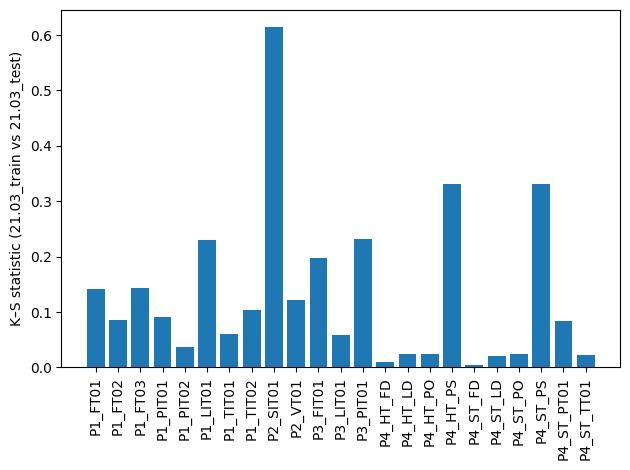

In [195]:

plt.bar(range(len(ks_Static)), list(ks_Static.values()))
plt.xticks(range(len(ks_Static)), list(ks_Static.keys()), rotation=90)
plt.ylabel("K–S statistic (21.03_train vs 21.03_test)")
plt.tight_layout()
plt.show()

In [196]:
actuators =  [
    'P1_FCV01Z',  # Feedback position of Flow Control Valve 01 (0–100 %)
    'P1_FCV02Z',  # Feedback position of Flow Control Valve 02 (0–100 %)
    'P1_FCV03Z',  # Feedback position of Flow Control Valve 03 (0–100 %)
    'P1_LCV01Z',  # Feedback position of Level Control Valve 01 (0–100 %)
    'P1_PCV01Z',  # Feedback position of Pressure Control Valve 01 (0–100 %)
    'P1_PCV02Z',  # Feedback position of Pressure Control Valve 02 (0–100 %)
    'P1_PP01AR',  # Running status of main pump PP01A (0/1)
    'P1_PP01BR',  # Running status of standby pump PP01B (0/1)
    'P1_PP02R'    # Running status of heating-water pump PP02 (0/1)
]

def quantize_valves(df, valve_cols, ignore=[], step=10):
    cols_to_quantize = [col for col in valve_cols if col not in ignore]
    df[cols_to_quantize] = df[cols_to_quantize].clip(lower=0, upper=100)
    df[cols_to_quantize] = df[cols_to_quantize].apply(lambda x: (x / step).round() * step)
    return df

In [197]:
def compute_common_states(train_df: pd.DataFrame, test_df: pd.DataFrame, actuator_cols: List[str]) -> List[Tuple]:
    """
    Quantize actuator values into discrete steps and find common states
    """
    print("\n=== Computing Common States ===")

    # convert each row into a tuple and store in a Python set (which keeps only unique combinations)
    train_s = set(tuple(row) for row in train_df[actuator_cols].to_numpy())
    test_s = set(tuple(row) for row in test_df[actuator_cols].to_numpy())

    common_states = train_s & test_s
    print(len(train_s), len(test_s))
    print(f"Common states: {len(common_states)}")
    return train_s, test_s, list(common_states)

In [198]:
print(len(train_df))
print(len(test_df))

216001
85773


In [199]:
a_train_df = train_df.copy()
a_test_df = test_df.copy()

In [200]:
a_train_df = quantize_valves(a_train_df, actuators, ignore=['P1_PP01BR','P1_PP02R'], step=5) # mutating df
print(a_train_df[actuators])
a_test_df = quantize_valves(a_test_df, actuators, ignore=['P1_PP01BR','P1_PP02R'], step=5) # mutating df

        P1_FCV01Z  P1_FCV02Z  P1_FCV03Z  P1_LCV01Z  P1_PCV01Z  P1_PCV02Z  \
0           100.0        0.0       55.0       10.0       40.0       10.0   
1           100.0        0.0       55.0       10.0       40.0       10.0   
2           100.0        0.0       55.0       10.0       40.0       10.0   
3           100.0        0.0       55.0       10.0       40.0       10.0   
4           100.0        0.0       55.0       10.0       40.0       10.0   
...           ...        ...        ...        ...        ...        ...   
215996        0.0       95.0       70.0       15.0      100.0       10.0   
215997        0.0       95.0       70.0       15.0      100.0       10.0   
215998        0.0       95.0       70.0       15.0      100.0       10.0   
215999        0.0       95.0       70.0       15.0      100.0       10.0   
216000        0.0       95.0       70.0       15.0      100.0       10.0   

        P1_PP01AR  P1_PP01BR  P1_PP02R  
0           100.0          0         1  
1    

In [201]:
train_s, test_s, common_states = compute_common_states(a_train_df, a_test_df, actuators)


=== Computing Common States ===
2685 519
Common states: 317


In [202]:
train_coverage_by_test = len(common_states) / len(train_s)
test_coverage_by_train = len(common_states) / len(test_s)

In [203]:

print("Train coverage by Test: {:.2f}%".format(train_coverage_by_test * 100))
print("Test coverage by Train: {:.2f}%".format(test_coverage_by_train * 100))

Train coverage by Test: 11.81%
Test coverage by Train: 61.08%


In [204]:
len(common_states)

317

In [205]:
a_train_df[hai_21_sensor_cols]

,P1_FT01,P1_FT02,P1_FT03,P1_PIT01,P1_PIT02,P1_LIT01,P1_TIT01,P1_TIT02,P2_SIT01,P2_VT01,...,P4_HT_FD,P4_HT_LD,P4_HT_PO,P4_HT_PS,P4_ST_FD,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01
0,166.74039,1973.19031,246.43968,1.36810,0.27786,395.19528,35.43700,35.74219,780.0,11.89504,...,-0.00072,0.06511,4.01474,0,-0.00297,301.35992,305.03113,0,10052.0,27610.0
1,168.64778,1975.47900,246.43968,1.36810,0.27634,395.14420,35.45227,35.74219,781.0,11.93421,...,-0.00051,0.04340,3.74347,0,0.00072,297.43567,304.27161,0,10052.0,27610.0
2,168.83849,1972.42725,246.05821,1.36734,0.27634,395.14420,35.45227,35.74219,780.0,11.97030,...,-0.00043,0.04340,3.43603,0,-0.00145,298.66534,303.89179,0,10050.0,27617.0
3,170.55510,1983.10828,246.63045,1.36734,0.27634,395.19528,35.43700,35.74219,780.0,12.01066,...,-0.00072,0.02170,3.12860,0,-0.00318,298.06860,303.67474,0,10052.0,27614.0
4,171.31805,1986.16016,246.24898,1.36810,0.27710,395.34866,35.45227,35.74219,782.0,11.99684,...,-0.00051,0.02170,2.87546,0,0.00015,296.53137,303.22266,0,10052.0,27621.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215996,216.90367,6.33237,315.67422,1.36353,0.20920,380.26914,36.35254,37.90893,775.0,11.99353,...,-0.00137,7.24103,27.86822,0,0.00181,334.90668,326.29846,0,10053.0,27627.0
215997,215.18706,6.71385,315.67422,1.36429,0.20844,380.32028,36.35254,37.87842,776.0,11.98806,...,-0.00159,5.98235,25.66186,0,0.00080,335.08752,327.20270,0,10052.0,27627.0
215998,213.66115,6.71385,315.48346,1.36276,0.20538,380.37140,36.36779,37.89367,778.0,11.97465,...,-0.00159,4.93346,23.18433,0,-0.00058,336.67895,328.03461,0,10053.0,27627.0
215999,218.62028,5.95089,315.67422,1.36353,0.20844,380.47360,36.35254,37.87842,778.0,11.94218,...,-0.00159,4.07262,21.35779,0,-0.00015,335.55768,328.39624,0,10051.0,27627.0


In [206]:
a_train_df_normalized, a_test_df_normalized = normalize_and_quantize(a_train_df[hai_21_sensor_cols], a_test_df[hai_21_sensor_cols], Q=None)



a_train_df_normalized.head()


=== Step 2: Normalizing & Quantizing (Q=None) ===
Data ranges before normalization:
  Train: min=-27.00, max=27629.00
  Test: min=-30.00, max=27627.00


,P1_FT01,P1_FT02,P1_FT03,P1_PIT01,P1_PIT02,P1_LIT01,P1_TIT01,P1_TIT02,P2_SIT01,P2_VT01,...,P4_HT_FD,P4_HT_LD,P4_HT_PO,P4_HT_PS,P4_ST_FD,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01
0,-1.191947,0.933786,-1.283881,-0.031411,-0.461065,-0.479841,-0.407249,-0.662165,0.293954,-0.222826,...,-0.302097,-1.025834,-0.965188,-0.304941,-1.793868,-0.789036,-0.767739,-0.304941,0.225334,0.064027
1,-1.117804,0.936393,-1.283881,-0.031411,-0.463971,-0.483197,-0.381629,-0.662165,0.541099,0.337028,...,-0.199761,-1.026485,-0.973837,-0.304941,0.451812,-0.894533,-0.790214,-0.304941,0.225334,0.064027
2,-1.110390,0.932916,-1.295775,-0.044380,-0.463971,-0.483197,-0.381629,-0.662165,0.293954,0.852860,...,-0.160776,-1.026485,-0.983640,-0.304941,-0.868818,-0.861475,-0.801454,-0.304941,0.106684,0.349489
3,-1.043663,0.945086,-1.277932,-0.044380,-0.463971,-0.479841,-0.407249,-0.662165,0.293954,1.429722,...,-0.302097,-1.027135,-0.993443,-0.304941,-1.921671,-0.877518,-0.807877,-0.304941,0.225334,0.227148
4,-1.014005,0.948563,-1.289827,-0.031411,-0.462518,-0.469765,-0.381629,-0.662165,0.788244,1.232194,...,-0.199761,-1.027135,-1.001514,-0.304941,0.104918,-0.918844,-0.821255,-0.304941,0.225334,0.512611


In [ ]:
# For each common state, get all matching sensor values
ks_statistics_per_state = {}

for state in common_states:
    train_mask = (a_train_df[actuators] == pd.Series(state, index=actuators)).all(axis=1)
    train_matching_rows = a_train_df[train_mask]
    #train_matching_rows[hai_21_sensor_cols]
    test_mask = (a_test_df[actuators] == pd.Series(state, index=actuators)).all(axis=1)
    test_matching_rows = a_test_df[test_mask]

    ks_statistics_per_state[state] = compare_datasets(train_matching_rows[hai_21_sensor_cols], test_matching_rows[hai_21_sensor_cols])

    
    


# Example: print sensor values for the first state


,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,P1_FCV01Z,...,P4_HT_PO,P4_HT_PS,P4_LD,P4_ST_FD,P4_ST_GOV,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01
42606,0.09823,1.52388,378.35913,1098.43835,32.00000,8.29700,166.04498,36.06415,15.62679,15.0,...,72.68152,0,442.47321,-0.00181,19725.0,368.65234,365.16199,0,10053.0,27626.0
42607,0.09823,1.52343,378.35913,1098.43835,32.00000,8.33410,160.08667,36.06300,15.66206,15.0,...,72.79010,0,442.09344,-0.00275,19769.0,368.70660,365.97583,0,10053.0,27623.0
42608,0.09823,1.52190,378.35913,1098.43835,32.00000,8.36828,158.10043,36.05919,15.68488,15.0,...,72.86237,0,443.59448,-0.00275,19808.0,370.60547,366.28332,0,10053.0,27627.0
117246,0.09938,1.35917,393.04804,1107.62415,32.10703,4.88607,167.03828,35.75652,14.72619,15.0,...,10.57941,0,323.16980,-0.00029,17339.0,321.65076,321.88580,0,10048.0,27627.0
117247,0.09938,1.35292,393.04804,1107.62415,32.10703,4.79249,165.05206,35.74088,14.74082,15.0,...,9.51242,0,321.83160,-0.00015,17328.0,320.45715,321.72308,0,10052.0,27627.0


In [224]:
ks_df = pd.DataFrame(ks_statistics_per_state).T

In [228]:
# Compute mean KS per sensor
avg_ks_per_sensor = ks_df.mean(axis=0).sort_values(ascending=False)

print("Average KS per sensor:")
print(avg_ks_per_sensor)

Average KS per sensor:
P1_TIT01      0.884315
P1_LIT01      0.875947
P1_TIT02      0.849385
P1_FT03       0.825829
P3_LIT01      0.746184
P2_SIT01      0.712121
P4_ST_TT01    0.710265
P3_PIT01      0.710005
P1_PIT01      0.652661
P3_FIT01      0.650430
P4_HT_PO      0.626044
P1_FT01       0.593256
P4_ST_PO      0.591786
P4_ST_LD      0.576049
P4_HT_LD      0.575911
P4_ST_PT01    0.469354
P1_FT02       0.439917
P4_HT_FD      0.432179
P1_PIT02      0.410187
P2_VT01       0.355615
P4_HT_PS      0.330400
P4_ST_PS      0.330400
P4_ST_FD      0.274451
dtype: float64


In [236]:

# Collect all sensor rows for common states from both train and test
all_train_sensor_rows = []
all_test_sensor_rows = []

for state in common_states:
    # Find all rows in a_train_df that match this state
    train_mask = (a_train_df[actuators] == pd.Series(state, index=actuators)).all(axis=1)
    train_matching_rows = a_train_df.loc[train_mask, hai_21_sensor_cols]
    
    # Add state identifier to each row
    train_matching_rows = train_matching_rows.copy()
    train_matching_rows['state'] = str(state)
    
    all_train_sensor_rows.append(train_matching_rows)
    
    # Find all rows in a_test_df that match this state
    test_mask = (a_test_df[actuators] == pd.Series(state, index=actuators)).all(axis=1)
    test_matching_rows = a_test_df.loc[test_mask, hai_21_sensor_cols]
    
    # Add state identifier to each row
    test_matching_rows = test_matching_rows.copy()
    test_matching_rows['state'] = str(state)
    
    all_test_sensor_rows.append(test_matching_rows)

# Combine all sensor data into DataFrames
train_sensor_data_df = pd.concat(all_train_sensor_rows, ignore_index=True)
test_sensor_data_df = pd.concat(all_test_sensor_rows, ignore_index=True)

print(f"Train shape: {train_sensor_data_df.shape}")
print(f"Test shape: {test_sensor_data_df.shape}")


Train shape: (89501, 24)
Test shape: (75849, 24)


In [238]:
ks_statistic_with_states = compare_datasets(train_sensor_data_df[hai_21_sensor_cols], test_sensor_data_df[hai_21_sensor_cols])

In [239]:
ks_statistic_with_states

{'P1_FT01': np.float64(0.18556085070742728),
 'P1_FT02': np.float64(0.2298776336800547),
 'P1_FT03': np.float64(0.20107808235408797),
 'P1_PIT01': np.float64(0.061647904538956244),
 'P1_PIT02': np.float64(0.14429580858752875),
 'P1_LIT01': np.float64(0.26153506814246213),
 'P1_TIT01': np.float64(0.1159139201291764),
 'P1_TIT02': np.float64(0.15588142650517278),
 'P2_SIT01': np.float64(0.6307209781098496),
 'P2_VT01': np.float64(0.1383518456584843),
 'P3_FIT01': np.float64(0.22090016468966583),
 'P3_LIT01': np.float64(0.06575086547103981),
 'P3_PIT01': np.float64(0.26509189716096354),
 'P4_HT_FD': np.float64(0.011159192810588525),
 'P4_HT_LD': np.float64(0.018062669201341475),
 'P4_HT_PO': np.float64(0.020810765011471943),
 'P4_HT_PS': np.float64(0.2736915482503066),
 'P4_ST_FD': np.float64(0.004958674197583668),
 'P4_ST_LD': np.float64(0.030658725509000312),
 'P4_ST_PO': np.float64(0.03540736507233708),
 'P4_ST_PS': np.float64(0.2736915482503066),
 'P4_ST_PT01': np.float64(0.0515619794